In [1]:
import json
import jsonschema
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [30]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
# Convert date column and add week/dayofweek
baseDf['date'] =  pd.to_datetime(baseDf['date'], format='%Y-%m-%d')
baseDf['week'] = baseDf['date'].dt.week + baseDf['date'].dt.year * 100
baseDf['day'] = baseDf['date'].dt.dayofweek
# Sort by region and date
baseDf = baseDf.sort_values(['region','date'])
# Additional cases
baseDf['new'] = baseDf['confirmed'] - baseDf['confirmed'].shift()
baseDf = baseDf[baseDf['date']>'2020-04-01'].reset_index()

In [31]:
with open('data/details_HU.json', 'r') as myfile:
    data_json = json.load(myfile)
with open('data/schema.json', 'r') as myfile:
    schema_json = json.load(myfile)
jsonschema.validate(data_json, schema_json)

In [32]:
df = pd.json_normalize(data_json)
# Remove template (source='')
df = df[df["source"]!=""]
# Convert date column and add week/dayofweek
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
df['week'] = df['date'].dt.week + df['date'].dt.year * 100
df['day'] = df['date'].dt.dayofweek
# Calculate actual
df["actual"] = df["cumulated.infected"]-df["cumulated.recoveredFromHospital"]-df["cumulated.deaths"]
# Calculate new
df["add.deaths"] = df.apply(
    lambda row: row["cumulated.deaths"]-df[
        df["date"]==row["date"] - pd.Timedelta(1, unit='D')
    ]["cumulated.deaths"].max(), 
    axis=1
)
df["add.infected"] = df.apply(
    lambda row: row["cumulated.infected"]-df[
        df["date"]==row["date"] - pd.Timedelta(1, unit='D')
    ]["cumulated.infected"].max(), 
    axis=1
)
df["add.recovered"] = df.apply(
    lambda row: row["cumulated.recoveredFromHospital"]-df[
        df["date"]==row["date"] - pd.Timedelta(1, unit='D')
    ]["cumulated.recoveredFromHospital"].max(), 
    axis=1
)
df = df[df['date']>'2020-04-01'].reset_index()

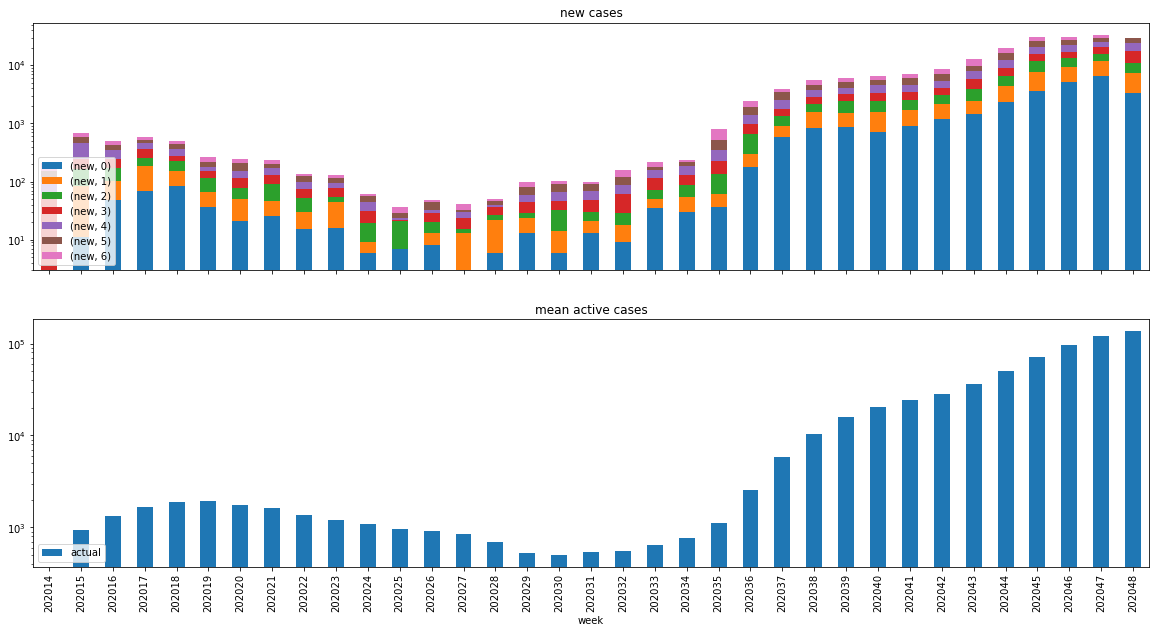

In [33]:
fig, ax = plt.subplots(nrows=2,figsize=(20,10),sharex=True)
ax[0].set_yscale("log")
baseDf.groupby(["week","day"]).agg({'new':'sum'}).unstack('day').plot(
    kind='bar', stacked=True, ax=ax[0], title='new cases'
)
ax[0].legend(loc="lower left")
df.groupby(["week"]).agg({'actual':'mean'}).plot(
    kind='bar', ax=ax[1], title='mean active cases'
)
ax[1].set_yscale("log")
ax[1].legend(loc="lower left")
plt.show()

In [34]:
addDf = df[["date","add.infected","add.deaths","add.recovered","active.infected","hospital","onVentilator"]].dropna()
addDf['hosp/active'] = addDf["hospital"]/addDf["active.infected"]*100
addDf['vent/hosp'] = addDf["onVentilator"]/addDf["hospital"]*100
addDf['week'] = addDf['date'].dt.week + addDf['date'].dt.year * 100
addDf['day'] = addDf['date'].dt.dayofweek
addDf.tail()

,date,add.infected,add.deaths,add.recovered,active.infected,hospital,onVentilator,hosp/active,vent/hosp,week,day
236,2020-11-24,3929.0,117.0,681.0,133853.0,7598.0,638.0,5.676376,8.396947,202048,1
237,2020-11-25,3806.0,106.0,0.0,137553.0,7718.0,656.0,5.610928,8.499611,202048,2
238,2020-11-26,6360.0,115.0,5596.0,138202.0,7537.0,640.0,5.453611,8.491442,202048,3
239,2020-11-27,6393.0,135.0,2510.0,141950.0,7591.0,647.0,5.347658,8.523251,202048,4
240,2020-11-28,6268.0,152.0,1895.0,146171.0,7536.0,644.0,5.155605,8.545648,202048,5


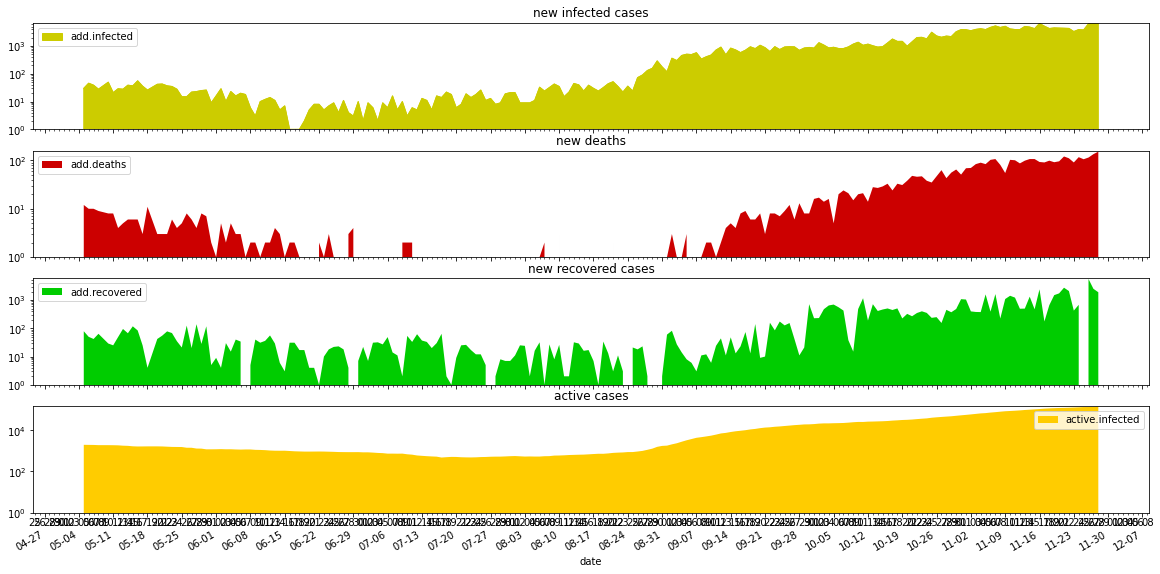

In [35]:
fig, ax = plt.subplots(nrows=4,figsize=(20,10),sharex=True)
addDf.plot(kind='area',x="date",y="add.infected",ax=ax[0],title='new infected cases',linewidth=1,color='#cc0')
addDf.plot(kind='area',x="date",y="add.deaths",ax=ax[1],title='new deaths',linewidth=0,color='#c00')
addDf.plot(kind='area',x="date",y="add.recovered",ax=ax[2],title='new recovered cases',linewidth=0,color='#0c0')
addDf.plot(kind='area',x="date",y="active.infected",ax=ax[3],title='active cases',linewidth=0,color='#fc0')
for i in range(0,4):
    ax[i].set_yscale("log")
    ax[i].set_ylim(1,None)
    ax[i].xaxis.set_minor_locator(dates.DayLocator(bymonthday=range(1,32), interval=1))
    ax[i].xaxis.set_minor_formatter(dates.DateFormatter('%d'))
    ax[i].xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
    ax[i].xaxis.set_major_formatter(dates.DateFormatter('\n%m-%d'))
plt.show()

In [36]:
population = 10000000
base = 100000
addDf["14d.add.infected_per_100_000"] = addDf.apply(
    lambda row: round((
        addDf[
            (addDf["date"] <= row["date"]) & (addDf["date"] > row["date"] - pd.DateOffset(14))
        ]["add.infected"].sum()
    ) / (
        addDf[
            (addDf["date"] <= row["date"]) & (addDf["date"] > row["date"] - pd.DateOffset(14))
        ]["add.infected"].count()
    ) * 14 * base / population, 2), axis=1
)
#addDf["weekly.add.infected"] = addDf.groupby('week')["add.infected"].transform('sum')
addDf.tail(7)

,date,add.infected,add.deaths,add.recovered,active.infected,hospital,onVentilator,hosp/active,vent/hosp,week,day,14d.add.infected_per_100_000
234,2020-11-22,4320.0,111.0,2095.0,127903.0,7278.0,618.0,5.690250,8.491344,202047,6,650.02
235,2020-11-23,3334.0,91.0,424.0,130722.0,7461.0,627.0,5.707532,8.403699,202048,0,631.74
236,2020-11-24,3929.0,117.0,681.0,133853.0,7598.0,638.0,5.676376,8.396947,202048,1,629.63
237,2020-11-25,3806.0,106.0,0.0,137553.0,7718.0,656.0,5.610928,8.499611,202048,2,628.24
238,2020-11-26,6360.0,115.0,5596.0,138202.0,7537.0,640.0,5.453611,8.491442,202048,3,652.57
239,2020-11-27,6393.0,135.0,2510.0,141950.0,7591.0,647.0,5.347658,8.523251,202048,4,665.53
240,2020-11-28,6268.0,152.0,1895.0,146171.0,7536.0,644.0,5.155605,8.545648,202048,5,679.85


In [37]:
limits = [
    {"date":"2020-05-06", "sup":150, "mid":50, "inf":25},
    {"date":"2020-11-01", "sup":150, "mid":50, "inf":25}
]
limits_df = pd.json_normalize(limits)
limits_df["date"] = pd.to_datetime(limits_df["date"])

envelope = [
    {"date":"2020-05-06", "trend":5}, {"date":"2020-05-25", "trend":5},
    {"date":"2020-06-20", "trend":1}, {"date":"2020-07-15", "trend":1},
    {"date":"2020-07-20", "trend":2}, {"date":"2020-08-05", "trend":2},
    {"date":"2020-08-25", "trend":5}, {"date":"2020-09-14", "trend":84},
    {"date":"2020-10-14", "trend":150}
]
# 16 days
env_df = pd.json_normalize(envelope)
env_df["date"] = pd.to_datetime(env_df["date"])

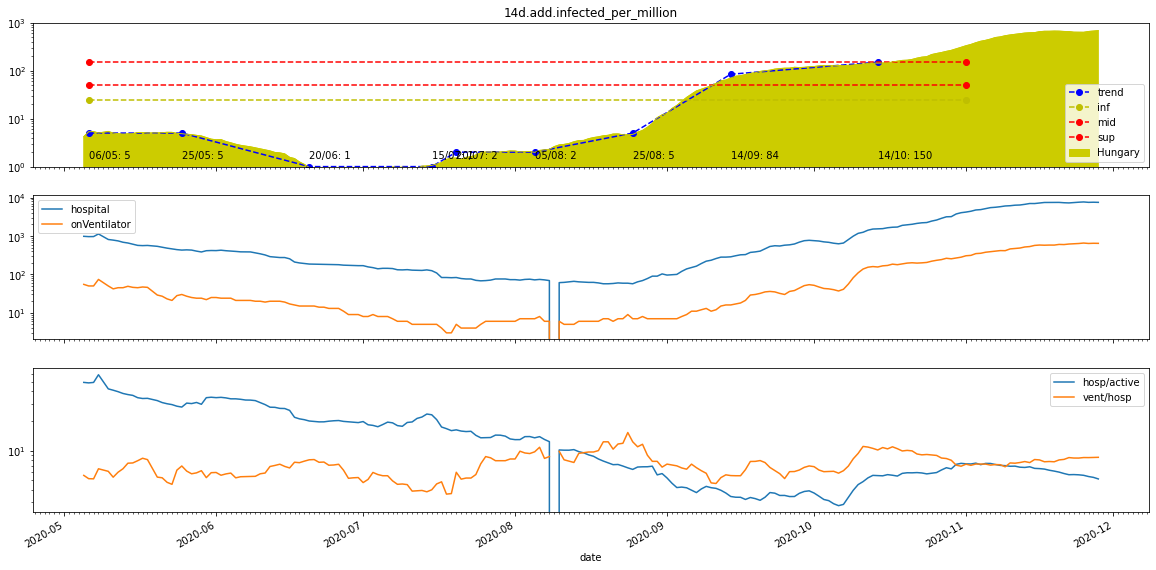

In [38]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10), sharex=True)
env_df.plot(ax=ax[0],x="date",y="trend",label="trend",style="bo--")
limits_df.plot(ax=ax[0],x="date",y="inf",label="inf",style="yo--")
limits_df.plot(ax=ax[0],x="date",y="mid",label="mid",style="ro--")
limits_df.plot(ax=ax[0],x="date",y="sup",label="sup",style="ro--")
addDf.plot(
    kind='area',x="date",y="14d.add.infected_per_100_000",ax=ax[0],
    title='14d.add.infected_per_million',label='Hungary',linewidth=1,color='#cc0')
for row in zip(env_df.values):
    for row_content in zip(row):
        for data in row_content:
            label = "{}: {}".format(data[0].strftime('%d/%m'), data[1])
            # ax.annotate(label,xy=(data[0], np.exp(np.log(data[1]))))
            ax[0].annotate(label,xy=(data[0], 1.5))
ax[0].set_yscale("log")
ax[0].set_ylim(1,1000)
ax[0].xaxis.set_minor_locator(dates.DayLocator(bymonthday=range(1,32), interval=1))
addDf.plot(x="date", y="hospital", ax=ax[1])
addDf.plot(x="date", y="onVentilator", ax=ax[1])
ax[1].set_yscale("log")
addDf.plot(x="date", y="hosp/active", ax=ax[2])
addDf.plot(x="date", y="vent/hosp", ax=ax[2])
ax[2].set_yscale("log")
plt.show()